In [1]:
# Imports
import os
import random
from glob import glob
import cv2 
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

import argparse
#import torch
#import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# DATA

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Load the data(images)
x_npz = np.load("../../data/x_images_arrays.npz")
X = x_npz["arr_0"]
y_npz = np.load("../../data/y_labels_arrays.npz")
Y = y_npz["arr_0"]

print(np.array(X).shape)
print(np.array(Y).shape)

# Separete the data into train and test sets
# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=1, stratify=Y)

#x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print(np.array(x_train).shape)
#print(np.array(x_val).shape)
print(np.array(x_test).shape)
# (3045, 128, 128, 3)
# (381, 128, 128, 3)
# (381, 128, 128, 3)

# Reduce the training dataset size to 401 images
# x_train_subset = x_train[:401]  # Select first 401 images
# y_train_subset = y_train[:401]  # Select corresponding labels
# print(np.array(x_train_subset).shape)  # (401, 128, 128, 3)
# print(np.array(y_train_subset).shape)  # (401,)

# Transform the data to tensor
# Define a transform
transform = transforms.Compose([
            #transforms.Resize((28, 28)),
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Apply the transform to the data
dataset_train = CustomImageDataset(x_train, y_train, transform=transform)
#dataset_val = CustomImageDataset(x_val, y_val, transform=transform)
dataset_test = CustomImageDataset(x_test, y_test, transform=transform)

img, label = dataset_train[0]
print(img.shape, label) # [grayscale=1, size=128, size=128] label=0 ('Nothing')
print(dataset_train.__len__()) # 3045 images
#print(dataset_val.__len__()) # 0 images
print(dataset_test.__len__()) # 762 images

# Load into the DataLoader
batch_size = 32

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


(3807, 128, 128, 3)
(3807,)
(3045, 128, 128, 3)
(762, 128, 128, 3)
torch.Size([1, 128, 128]) 0
3045
762


# NETWORK

### Define

In [ ]:
# Network Architecture
entry_channels = 1
mid_channels = 6
exit_channels = 16
kernel_size = 5
padding = 2
num_inputs = 128*128
num_hidden = 1000
num_outputs = 3 # classes
num_steps = 50
beta = 0.95

# Use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
dtype = torch.float
class SpkLeNet(nn.Module):
    def __init__(self):
        super(SpkLeNet, self).__init__()
        # Camada convolucional 1: 1 canal -> 6 canais, kernel 5x5, padding 2
        self.conv1 = nn.Conv2d(entry_channels, mid_channels, kernel_size, padding=padding, stride=1)
        # Max pooling 2x2
        self.lif1 = snn.Leaky(beta=beta)
        self.pool = nn.MaxPool2d(2, 2)
        # Camada convolucional 2: 6 canais -> 16 canais, kernel 5x5
        self.conv2 = nn.Conv2d(mid_channels, exit_channels, kernel_size)
        self.lif2 = snn.Leaky(beta=beta)
        # Camadas fully connected 
        self.fc1 = nn.Linear(exit_channels * 30 * 30, 120)  # 30x30 após conv2+pool2
        self.lif3 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(120, 84)
        self.lif4 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(84, num_outputs)
        self.lif5 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        # Record the final layer
        spk5_rec = []
        mem5_rec = []

        for step in range(num_steps):
            cur1 = self.conv1(x[step, :, :, :, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            pool1 = self.pool(spk1)
            cur2 = self.conv2(pool1)
            spk2, mem2 = self.lif2(cur2, mem2)
            pool2 = self.pool(spk2)
            flat = torch.flatten(pool2, 1)

            cur3 = self.fc1(flat)
            spk3, mem3 = self.lif3(cur3, mem3)
            cur4 = self.fc2(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            cur5 = self.fc3(spk4)
            spk5, mem5 = self.lif5(cur5, mem5) # testar com saida direto da fc3

            spk5_rec.append(spk5)
            mem5_rec.append(mem5)

        return torch.stack(spk5_rec, dim=0), torch.stack(mem5_rec, dim=0)

# Instanciar o modelo
spklenet = SpkLeNet().to(device)

In [18]:
# Metrics
# Accuracy
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = spklenet(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(spike_data, targets, train=True)
    print_batch_accuracy(test_spike_data, test_targets, train=False)
    print("\n")

# loss
loss = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(spklenet.parameters(), lr=5e-4, betas=(0.9, 0.999))

### Training Loop

In [ ]:
# Training loop
num_epochs = 4
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data, targets in train_batch:
        #print(epoch, iter_counter, counter)
        data = data.to(device)
        targets = targets.to(device)
        #print(f"Targets shape: {targets.shape}")
        # forward pass
        spklenet.train()
        spike_data = spikegen.latency(data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)
        #print(f"Spike data shape (latency 2): {spike_data.shape}")

        spk_rec, mem_rec = spklenet(spike_data)
        #print(f"mem_rec shape: {mem_rec.shape}")  # Should be (num_steps, N, num_outputs)
        #print(f"mem_rec[step] shape: {mem_rec[0].shape}")  # Should be (N, num_outputs)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
 
        # Test set
        with torch.no_grad():
            spklenet.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            test_spike_data = spikegen.latency(test_data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)

            # Test set forward pass
            test_spk, test_mem = spklenet(test_spike_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 32 == 0:
                train_printer()
            counter += 1
            iter_counter += 1

Epoch 0, Iteration 0
Train Set Loss: 65.67
Test Set Loss: 53.02
Train set accuracy for a single minibatch: 75.00%
Test set accuracy for a single minibatch: 78.12%


Epoch 0, Iteration 32
Train Set Loss: 30.61
Test Set Loss: 36.43
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 81.25%


Epoch 0, Iteration 64
Train Set Loss: 32.58
Test Set Loss: 33.75
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 84.38%


Epoch 1, Iteration 0
Train Set Loss: 45.61
Test Set Loss: 31.60
Train set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 84.38%


Epoch 1, Iteration 32
Train Set Loss: 26.63
Test Set Loss: 29.42
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 87.50%


Epoch 1, Iteration 64
Train Set Loss: 41.48
Test Set Loss: 44.64
Train set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 62.50%


Epoch 

In [23]:
# Código extra para salvar o modelo
PATH = '../../models/snn_conv_4.pth'
torch.save(spklenet.state_dict(), PATH)
print(f"Modelo salvo com sucesso em: {PATH}")

Modelo salvo com sucesso em: ../../models/snn_conv_4.pth


### Metrics

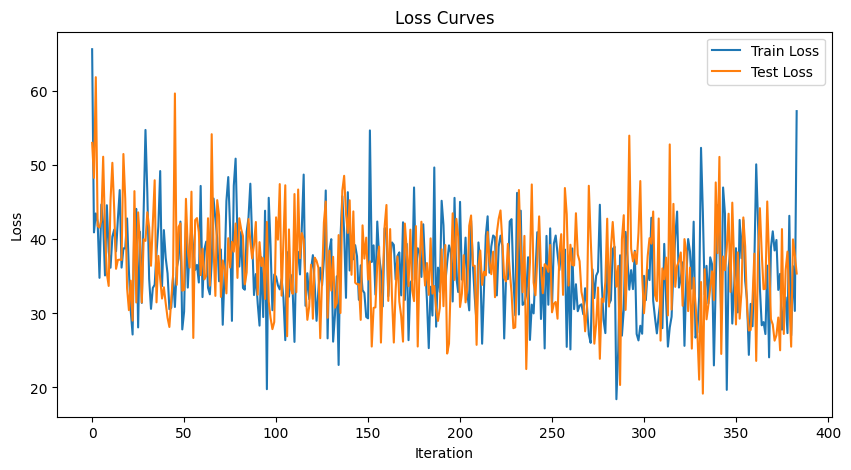

In [20]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [21]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro') # average = 'weighted' | 'micro' | 'macro'
    return precision, recall, f1

# Listas para armazenar previsões e rótulos verdadeiros
all_preds = []
all_targets = []

# Avaliação do modelo
total = 0
correct = 0

with torch.no_grad():
    spklenet.eval()
    for data_2, targets_2 in test_loader:
        data_2 = data_2.to(device)
        targets_2 = targets_2.to(device)

        # Converter dados para spikes
        spike_data_2 = spikegen.latency(data_2, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)

        # Forward pass
        test_spk, _ = spklenet(spike_data_2)

        # Previsões
        _, predicted = test_spk.sum(dim=0).max(1)

        # Acumular acurácia
        total += targets_2.size(0)
        correct += (predicted == targets_2).sum().item()

        # Armazenar previsões e rótulos para F1 e matriz de confusão
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets_2.cpu().numpy())

# Calcular acurácia
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

# Calcular precisão, recall e F1-score
precision, recall, f1 = calculate_metrics(all_targets, all_preds) 
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Calcular e exibir a matriz de confusão
conf_matrix = confusion_matrix(all_targets, all_preds)
print("\nMatriz de Confusão:")
print(conf_matrix)


Total correctly classified test set images: 609/762
Test Set Accuracy: 79.92%
Precision: 0.27
Recall: 0.33
F1-score: 0.30

Matriz de Confusão:
[[609   0   0]
 [ 52   0   0]
 [101   0   0]]


c:\Users\giueg\.virtualenvs\TCC_25-OGy0qkdu\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


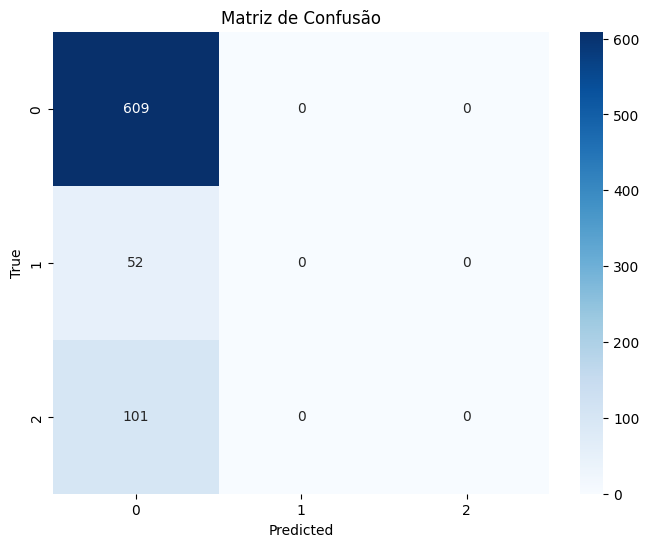

In [22]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()